# Combining Datasets: Merge and Join

One essential feature offered by Pandas is its high-performance, in-memory join and merge operations.
If you have ever worked with databases, you should be familiar with this type of data interaction.
The main interface for this is the ``pd.merge`` function, and we'll see few examples of how this can work in practice.

For convenience, we will start by defining the `display()` to display the printed DataFrames side-by-side:

In [2]:
from IPython.display import Pretty as disp
hint = 'https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/docs/hints/'  # path to hints on GitHub

import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Relational Algebra

The behavior implemented in ``pd.merge()`` is a subset of what is known as *relational algebra*, which is a formal set of rules for manipulating relational data, and forms the conceptual foundation of operations available in most databases.
The strength of the relational algebra approach is that it proposes several primitive operations, which become the building blocks of more complicated operations on any dataset.
With this lexicon of fundamental operations implemented efficiently in a database or other program, a wide range of fairly complicated composite operations can be performed.

Pandas implements several of these fundamental building-blocks in the ``pd.merge()`` function and the related ``join()`` method of ``Series`` and ``Dataframe``s.
As we will see, these let you efficiently link data from different sources.

## Categories of Joins

The ``pd.merge()`` function implements a number of types of joins: the *one-to-one*, *many-to-one*, and *many-to-many* joins.
All three types of joins are accessed via an identical call to the ``pd.merge()`` interface; the type of join performed depends on the form of the input data.
Here we will show simple examples of the three types of merges, and discuss detailed options further below.

### One-to-one joins

Perhaps the simplest type of merge expresion is the one-to-one join.

As a concrete example, consider the following two ``DataFrames`` which contain information on several students at Questrom:

In [14]:
employees = pd.DataFrame({
    'EmployeeID': [104, 102, 101, 103],
    'EmployeeName': ['Alice', 'Bob', 'David', 'Charlie'],
    'DepartmentID': [1, 2, 1, 3]
})

emails = pd.DataFrame({
    'EmployeeID': [102, 104, 103, 101],
    'Email': ['bob@email.com', 'alice@email.com', 'charlie@email.com', 'david@email.com']
})

departments = pd.DataFrame({
    'DepartmentID': [1, 2, 3, 4],
    'DepartmentName': ['HR', 'Finance', 'Engineering', 'Marketing'],
    'DepartmentFloor': [2, 2, 1, 2]
})

salaries = pd.DataFrame({
    'EmployeeID': [101, 102, 103, 104, 105],
    'Salary': [50000, 60000, 70000, 80000, 60000]
})

display('employees', 'emails', 'departments', 'salaries')

employees
   EmployeeID EmployeeName  DepartmentID
0         104        Alice             1
1         102          Bob             2
2         101        David             1
3         103      Charlie             3

emails
   EmployeeID              Email
0         102      bob@email.com
1         104    alice@email.com
2         103  charlie@email.com
3         101    david@email.com

departments
   DepartmentID DepartmentName  DepartmentFloor
0             1             HR                2
1             2        Finance                2
2             3    Engineering                1
3             4      Marketing                2

salaries
   EmployeeID  Salary
0         101   50000
1         102   60000
2         103   70000
3         104   80000
4         105   60000

To combine this information into a single ``DataFrame``, we can use the ``pd.merge()`` function:

In [19]:
pd.merge(employees, emails)

,EmployeeID,EmployeeName,DepartmentID,Email
0,104,Alice,1,alice@email.com
1,102,Bob,2,bob@email.com
2,101,David,1,david@email.com
3,103,Charlie,3,charlie@email.com


The ``pd.merge()`` function recognizes that each ``DataFrame`` has a "EmployeeID" column, and automatically joins using this column as a key.
The result of the merge is a new ``DataFrame`` that combines the information from the two inputs.
Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "EmployeeID" column differs between ``employees`` and ``emails``, and the ``pd.merge()`` function correctly accounts for this.
Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (see the ``left_index`` and ``right_index`` keywords, discussed momentarily).

### Many-to-one joins

Many-to-one joins are joins in which one of the two key columns contains duplicate entries.
For the many-to-one case, the resulting ``DataFrame`` will preserve those duplicate entries as appropriate.
Consider the following example of a many-to-one join:

In [12]:
display('employees', 'departments', 'pd.merge(employees, departments)')

employees
   EmployeeID EmployeeName  DepartmentID
0         104        Alice             1
1         102          Bob             2
2         101        David             1
3         103      Charlie             3

departments
   DepartmentID DepartmentName
0             1             HR
1             2        Finance
2             3    Engineering
3             4      Marketing

pd.merge(employees, departments)
   EmployeeID EmployeeName  DepartmentID DepartmentName
0         104        Alice             1             HR
1         101        David             1             HR
2         102          Bob             2        Finance
3         103      Charlie             3    Engineering

The resulting ``DataFrame`` has an aditional column with the "DepartmentName" information, where the information is repeated in one or more locations as required by the inputs.

### Many-to-many joins

Many-to-many joins are a bit confusing conceptually, but are nevertheless well defined.
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.
This will be perhaps most clear with a concrete example.
Consider the following, where we have a ``DataFrame`` showing one or more technologies associated with a particular project.
By performing a many-to-many join, we can recover the technologies associated with any individual employee:

In [22]:
employee_projects = pd.DataFrame({
    'Employee': [101, 101, 102, 103, 103, 104],
    'Project': ['WebApp', 'MobileApp', 'Database', 'WebApp', 'API', 'MobileApp']
})

project_technologies = pd.DataFrame({
    'Project': ['WebApp', 'WebApp', 'MobileApp', 'MobileApp', 'API', 'Database'],
    'Technology': ['JavaScript', 'HTML', 'Swift', 'Kotlin', 'Python', 'SQL']
})

display('employee_projects', 'project_technologies', "pd.merge(employee_projects, project_technologies)")

,Employee,Project
0,101,WebApp
1,101,MobileApp
2,102,Database
3,103,WebApp
4,103,API
5,104,MobileApp
,Project,Technology
0,WebApp,JavaScript
1,WebApp,HTML
2,MobileApp,Swift


These three types of joins can be used with other Pandas tools to implement a wide array of functionality.

# Your turn

In the following cell we are loading two datasets: 1) `movies`, consists of metadata information about 1682 movies from 1969 to 1995. 2) `ratings`, includes 100,000 ratings on these movies.

In [ ]:
movies = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/movies_metadata.csv', encoding='latin-1')  # encoding='latin-1' was used
ratings = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/movies_ratings.csv', sep='\t')  # tab separated data
display('ratings.head()', 'movies.head()')

ratings.head()
   user_id  movie_id  rating  rating_timestamp
0      196       242       3         881250949
1      186       302       3         891717742
2       22       377       1         878887116
3      244        51       2         880606923
4      166       346       1         886397596

movies.head()
   movie_id        movie_title release_date  ... Thriller  War  Western
0         1   Toy Story (1995)     1-Jan-95  ...      0.0  0.0      0.0
1         2   GoldenEye (1995)     1-Jan-95  ...      1.0  0.0      0.0
2         3  Four Rooms (1995)     1-Jan-95  ...      1.0  0.0      0.0
3         4  Get Shorty (1995)     1-Jan-95  ...      0.0  0.0      0.0
4         5     Copycat (1995)     1-Jan-95  ...      1.0  0.0      0.0

[5 rows x 23 columns]

We only need the movie title and ID from `movies`; let's select only those two columns and get rid of the rest:

In [ ]:
# Your code goes here


In [ ]:
movies.head(2)

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [ ]:
# SOLUTION: Uncomment and execute the cell below to get help
#disp(hint + '09-03-select-columns')

movies = movies[['movie_id', 'movie_title']]


From the `ratings` dataframe find the average rating for each movie_id and save it to a DataFrame called `avg_rating`:

In [ ]:
# Your code goes here


In [ ]:
avg_rating.head()

,rating
movie_id,
1,3.878319
2,3.206107
3,3.033333
4,3.550239
5,3.302326


In [ ]:
# HINT: Uncomment and execute the line below to get help
#disp(hint + '09-03-agg-hint')

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-agg')

Merge `movies` with `avg_rating` DataFrame to bring the title name of each movie_id. Call this DataFrame `avg_rating_w_title`:

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title.head()

,rating,movie_id,movie_title
0,3.878319,1,Toy Story (1995)
1,3.206107,2,GoldenEye (1995)
2,3.033333,3,Four Rooms (1995)
3,3.550239,4,Get Shorty (1995)
4,3.302326,5,Copycat (1995)


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-merge-movies')

Let's sort the columns of `avg_rating_w_title` in the order of `movie_title` | `rating` and make the `movie_id` the index. No need to provide a new name for this dataframe, just overwrite it:

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title.head()

,movie_title,rating
movie_id,,
1,Toy Story (1995),3.878319
2,GoldenEye (1995),3.206107
3,Four Rooms (1995),3.033333
4,Get Shorty (1995),3.550239
5,Copycat (1995),3.302326


In [ ]:
# HINT: Uncomment and execute the line below to get help
#disp(hint + '09-03-sort-columns')

Sort this `avg_rating_w_title` DataFrame inplace (top rated movies on top):

In [ ]:
# Your code goes here


In [ ]:
avg_rating_w_title

,movie_title,rating
movie_id,,
814,Great Day in Harlem,5.0
1599,Someone Else's America (1995),5.0
1201,Marlene Dietrich: Shadow and Light (1996),5.0
1122,They Made Me a Criminal (1939),5.0
1653,Entertaining Angels: The Dorothy Day Story (1996),5.0
...,...,...
1568,Vermont Is For Lovers (1992),1.0
1567,Careful (1992),1.0
1566,Man from Down Under,1.0


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-sort-movies')

In practice, datasets are rarely as clean as the one we're working with here. In the following section we'll consider some of the options provided by ``pd.merge()`` that enable you to tune how the join operations work.

## Specification of the Merge Key

We've already seen the default behavior of ``pd.merge()``: it looks for one or more matching column names between the two inputs, and uses this as the key.
However, often the column names will not match so nicely, and ``pd.merge()`` provides a variety of options for handling this.

### The ``on`` keyword

Most simply, you can explicitly specify the name of the key column using the ``on`` keyword, which takes a column name or a list of column names:

In [21]:
display('employees', 'emails', "pd.merge(employees, emails, on='EmployeeID')")

employees
   EmployeeID EmployeeName  DepartmentID
0         104        Alice             1
1         102          Bob             2
2         101        David             1
3         103      Charlie             3

emails
   EmployeeID              Email
0         102      bob@email.com
1         104    alice@email.com
2         103  charlie@email.com
3         101    david@email.com

pd.merge(employees, emails, on='EmployeeID')
   EmployeeID EmployeeName  DepartmentID              Email
0         104        Alice             1    alice@email.com
1         102          Bob             2      bob@email.com
2         101        David             1    david@email.com
3         103      Charlie             3  charlie@email.com

This option works only if both the left and right ``DataFrame``s have the specified column name.

### The ``left_on`` and ``right_on`` keywords

At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee ID is labeled as "Employee" rather than "EmployeeID".
In this case, we can use the ``left_on`` and ``right_on`` keywords to specify the two column names:

In [23]:
display('employees', 'employee_projects', 'pd.merge(employees, employee_projects, left_on="EmployeeID", right_on="Employee")')

employees
   EmployeeID EmployeeName  DepartmentID
0         104        Alice             1
1         102          Bob             2
2         101        David             1
3         103      Charlie             3

employee_projects
   Employee    Project
0       101     WebApp
1       101  MobileApp
2       102   Database
3       103     WebApp
4       103        API
5       104  MobileApp

pd.merge(employees, employee_projects, left_on="EmployeeID", right_on="Employee")
   EmployeeID EmployeeName  DepartmentID  Employee    Project
0         104        Alice             1       104  MobileApp
1         102          Bob             2       102   Database
2         101        David             1       101     WebApp
3         101        David             1       101  MobileApp
4         103      Charlie             3       103     WebApp
5         103      Charlie             3       103        API

The result has a redundant column that we can drop if desired–for example, by using the ``drop()`` method of ``DataFrame``s:

In [24]:
pd.merge(employees, employee_projects, left_on="EmployeeID", right_on="Employee").drop('Employee', axis=1)

,EmployeeID,EmployeeName,DepartmentID,Project
0,104,Alice,1,MobileApp
1,102,Bob,2,Database
2,101,David,1,WebApp
3,101,David,1,MobileApp
4,103,Charlie,3,WebApp
5,103,Charlie,3,API


### The ``left_index`` and ``right_index`` keywords

Sometimes, rather than merging on a column, you would instead like to merge on an index.
For example, your data might look like this:

In [25]:
employees_i = employees.set_index('EmployeeID')
salaries_i = salaries.set_index('EmployeeID')
display('employees_i', 'salaries_i')

employees_i
           EmployeeName  DepartmentID
EmployeeID                           
104               Alice             1
102                 Bob             2
101               David             1
103             Charlie             3

salaries_i
            Salary
EmployeeID        
101          50000
102          60000
103          70000
104          80000
105          60000

You can use the index as the key for merging by specifying the ``left_index`` and/or ``right_index`` flags in ``pd.merge()``:

In [27]:
display("pd.merge(employees_i, salaries_i, left_index=True, right_index=True)")

,EmployeeName,DepartmentID,Salary
EmployeeID,,,
104,Alice,1,80000
102,Bob,2,60000
101,David,1,50000
103,Charlie,3,70000


For convenience, ``DataFrame``s implement the ``join()`` method, which performs a merge that defaults to joining on indices:

In [28]:
display("employees_i.join(salaries_i)")

,EmployeeName,DepartmentID,Salary
EmployeeID,,,
104,Alice,1,80000
102,Bob,2,60000
101,David,1,50000
103,Charlie,3,70000


If you'd like to mix indices and columns, you can combine ``left_index`` with ``right_on`` or ``left_on`` with ``right_index`` to get the desired behavior:

In [29]:
display('employees_i', 'salaries', "pd.merge(employees_i, salaries, left_index=True, right_on='EmployeeID')")

,EmployeeName,DepartmentID
EmployeeID,,
104,Alice,1
102,Bob,2
101,David,1
103,Charlie,3
,EmployeeID,Salary
0,101,50000
1,102,60000
2,103,70000
3,104,80000


All of these options also work with multiple indices and/or multiple columns; the interface for this behavior is very intuitive.
For more information on this, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.

# Your turn

In the previous exercise we calculated the average rating in `avg_rating_w_title` DataFrame. Let's find out how many ratings each movie had and then join it with `avg_rating_w_title`.

First, using groupby count the number of ratings for each `movie_id`. Call the resulting DataFrame `n_rating`. Use column `movie_id` for counting and call the resulting column in this dataframe `n_rating`:

In [ ]:
# Your code goes here


In [ ]:
display('avg_rating_w_title.head()', 'n_rating.head()')

avg_rating_w_title.head()
                                                movie_title  rating
movie_id                                                           
814                                     Great Day in Harlem     5.0
1599                          Someone Else's America (1995)     5.0
1201             Marlene Dietrich: Shadow and Light (1996)      5.0
1122                         They Made Me a Criminal (1939)     5.0
1653      Entertaining Angels: The Dorothy Day Story (1996)     5.0

n_rating.head()
          n_ratings
movie_id           
1               452
2               131
3                90
4               209
5                86

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-count_rating')

Merge (join) `avg_rating_w_title` and `n_rating`, call it `movie_rating`:

In [ ]:
# Your code goes here


In [ ]:
movie_rating.head()

,movie_title,rating,n_ratings
movie_id,,,
814,Great Day in Harlem,5.0,1
1599,Someone Else's America (1995),5.0,1
1201,Marlene Dietrich: Shadow and Light (1996),5.0,1
1122,They Made Me a Criminal (1939),5.0,1
1653,Entertaining Angels: The Dorothy Day Story (1996),5.0,1


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-movie_rating')

Since `avg_rating` was already sorted this will give us a sorted DataFrame. Let's take out all the movies that don't have at least 200 votes. Also, replace the index by `movie_title`:

In [ ]:
# Your code goes here


In [ ]:
movie_rating.head(10)

,rating,n_ratings
movie_title,,
Schindler's List (1993),4.466443,298
Casablanca (1942),4.456790,243
Shawshank Redemption,4.445230,283
Rear Window (1954),4.387560,209
Usual Suspects,4.385768,267
Star Wars (1977),4.358491,583
To Kill a Mockingbird (1962),4.292237,219
One Flew Over the Cuckoo's Nest (1975),4.291667,264
Silence of the Lambs,4.289744,390


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-filter-movies')

## Specifying Set Arithmetic for Joins

In all the preceding examples we have glossed over one important consideration in performing a join: the type of set arithmetic used in the join.

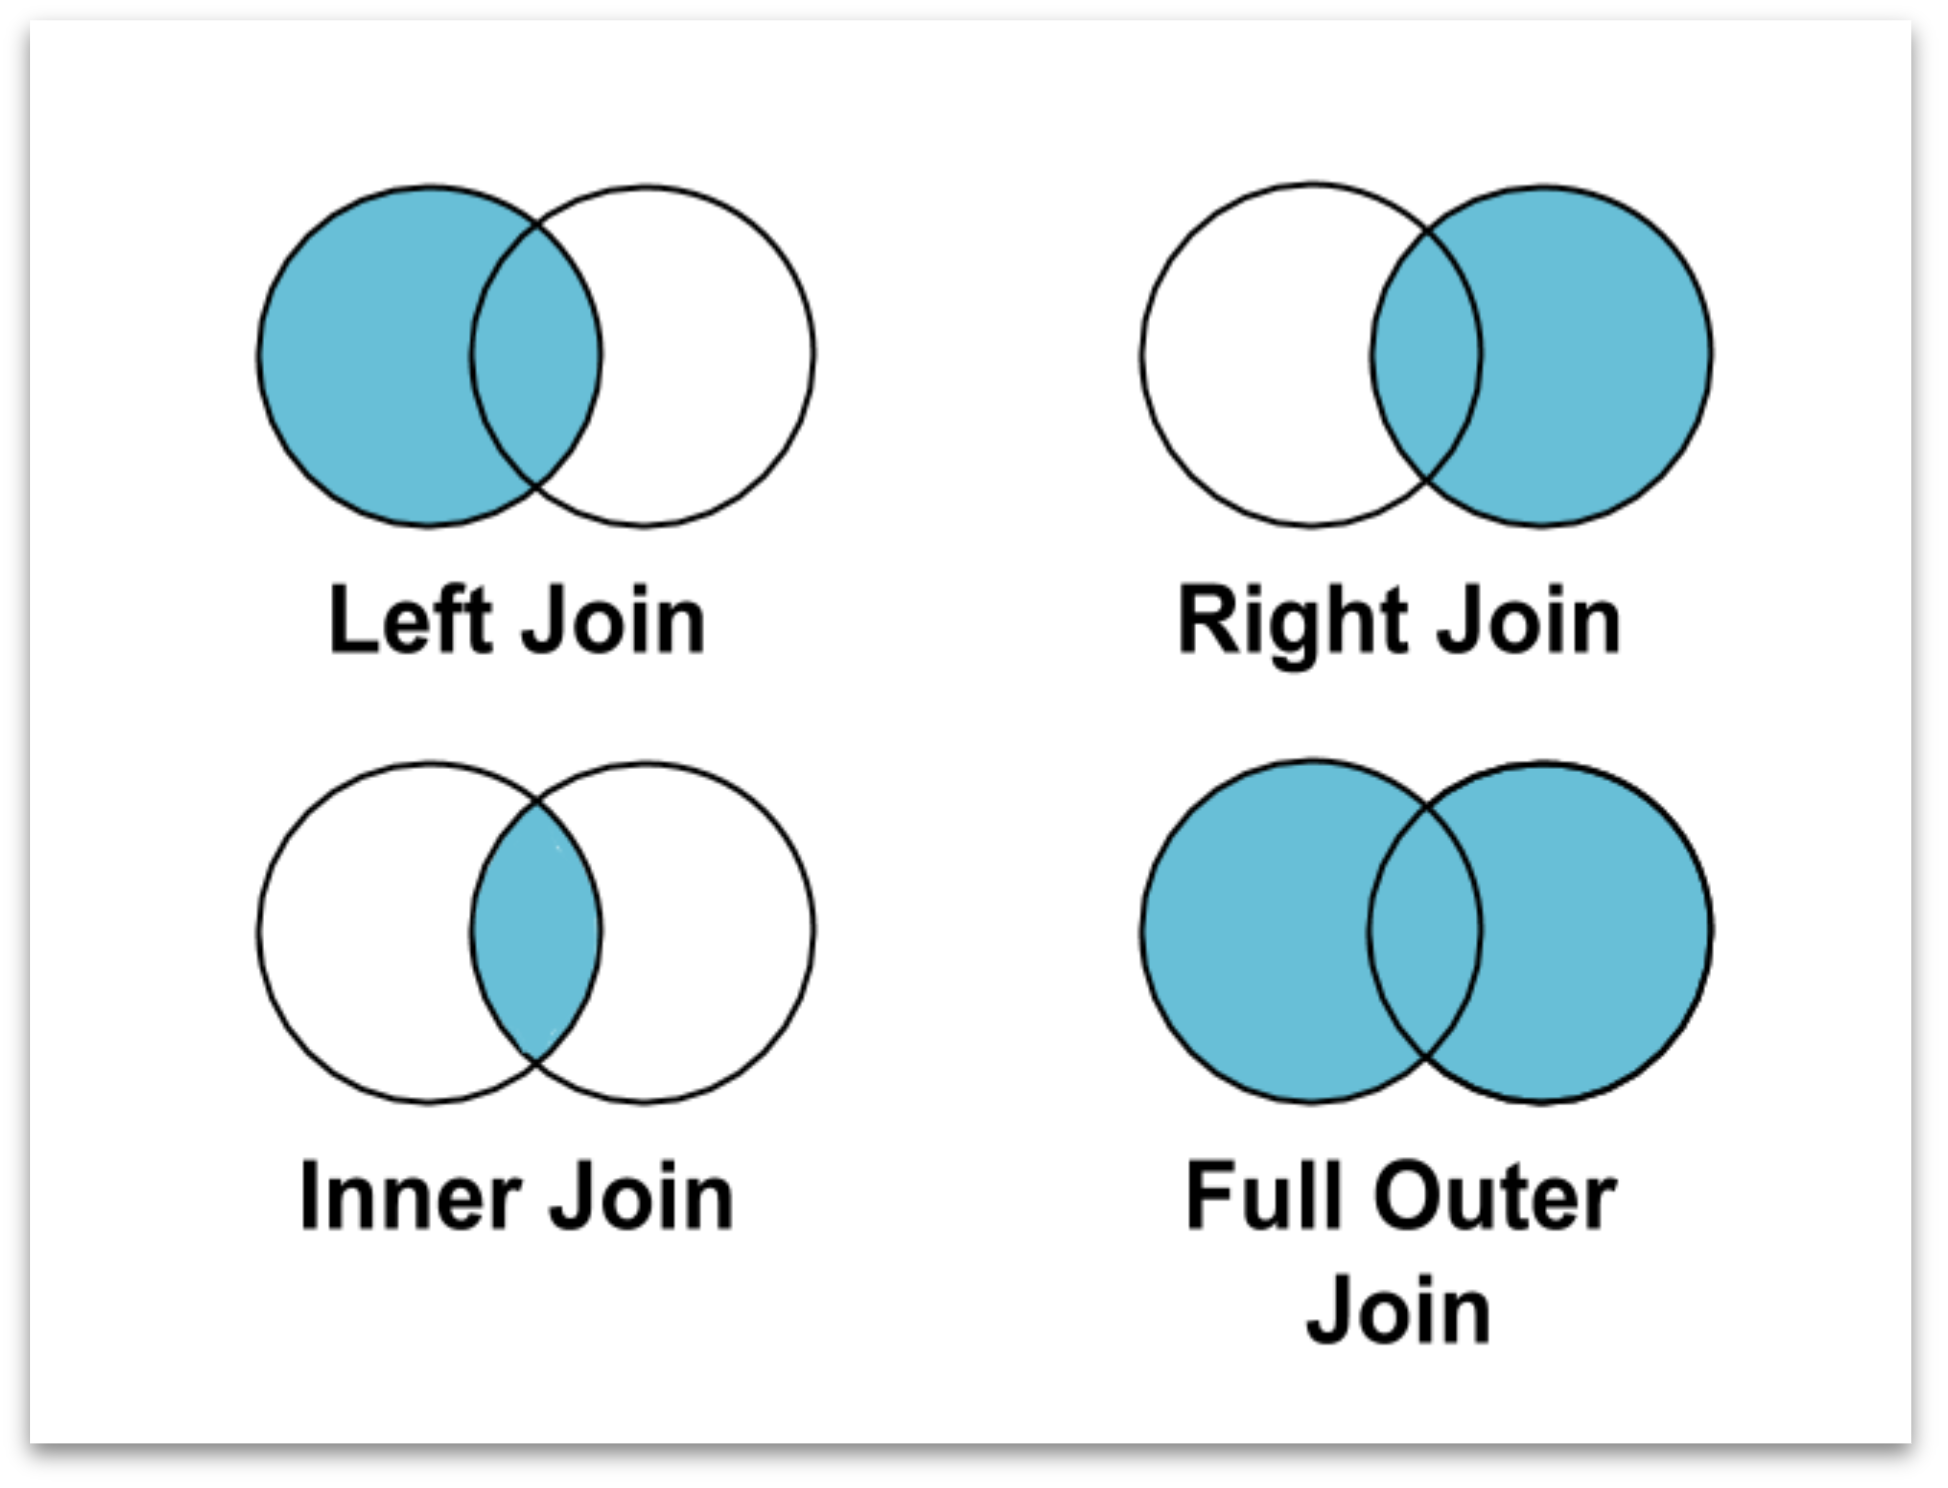

This comes up when a value appears in one key column but not the other. Consider this example:

- `customers_df`: Contains information about customers and their assigned sales representatives.

- `sales_reps_df`: Contains information about sales representatives and their regions.

In [30]:
customers_df = pd.DataFrame({
    'CustomerID': [1, 2, 3],
    'CustomerName': ['John', 'Jane', 'Jake'],
    'SalesRep': ['A', 'B', 'C']
})

sales_reps_df = pd.DataFrame({
    'SalesRep': ['A', 'B', 'D'],
    'Region': ['North', 'South', 'West']
})

display('customers_df', 'sales_reps_df', 'pd.merge(customers_df, sales_reps_df)')

customers_df
   CustomerID CustomerName SalesRep
0           1         John        A
1           2         Jane        B
2           3         Jake        C

sales_reps_df
  SalesRep Region
0        A  North
1        B  South
2        D   West

pd.merge(customers_df, sales_reps_df)
   CustomerID CustomerName SalesRep Region
0           1         John        A  North
1           2         Jane        B  South

Here we have merged two datasets that have only two "SalesRep" entry in common: A & B.
By default, the result contains the *intersection* of the two sets of inputs; this is what is known as an *inner join*.
We can specify this explicitly using the ``how`` keyword, which defaults to ``"inner"``:

In [31]:
pd.merge(customers_df, sales_reps_df, how='inner')

,CustomerID,CustomerName,SalesRep,Region
0,1,John,A,North
1,2,Jane,B,South


Other options for the ``how`` keyword are ``'outer'``, ``'left'``, and ``'right'``.
An *outer join* returns a join over the union of the input columns, and fills in all missing values with NAs:

In [32]:
pd.merge(customers_df, sales_reps_df, how='outer')

,CustomerID,CustomerName,SalesRep,Region
0,1.0,John,A,North
1,2.0,Jane,B,South
2,3.0,Jake,C,NaN
3,NaN,NaN,D,West


The *left join* and *right join* return joins over the left entries and right entries, respectively.
For example:

In [33]:
pd.merge(customers_df, sales_reps_df, how='left')

,CustomerID,CustomerName,SalesRep,Region
0,1,John,A,North
1,2,Jane,B,South
2,3,Jake,C,NaN


The output rows now correspond to the entries in the left input. Using
``how='right'`` works in a similar manner.

In [34]:
pd.merge(customers_df, sales_reps_df, how='right')

,CustomerID,CustomerName,SalesRep,Region
0,1.0,John,A,North
1,2.0,Jane,B,South
2,NaN,NaN,D,West


All of these options can be applied straightforwardly to any of the preceding join types.

# Combining Datasets: Concatenate (UNION)
We can combine or concatenate datasets of the same shape with the same column names and data types. This is particularely useful when store datasets for different years in different files/dataframes and for certain analyses would want to combine them. Here is a simple example:

In [ ]:
sales_2020 = pd.DataFrame({'customer_id': ['CGN-201', 'CGN-202'],
                    'total_purchase': [100, 150]})

sales_2019 = pd.DataFrame({'customer_id': ['CGN-191', 'CGN-192', 'CGN-193'],
                    'total_purchase': [120, 90, 450]})

sales_2018 = pd.DataFrame({'customer_id': ['CGN-181'],
                    'total_purchase': [50]})

print('sales_2020:')
print(sales_2020)
print('\nsales_2019:\n')
print(sales_2019)
print('\nsales_2018:\n')
print(sales_2018)

sales_2020:
  customer_id  total_purchase
0     CGN-201             100
1     CGN-202             150

sales_2019:

  customer_id  total_purchase
0     CGN-191             120
1     CGN-192              90
2     CGN-193             450

sales_2018:

  customer_id  total_purchase
0     CGN-181              50


In [ ]:
pd.concat([sales_2020, sales_2019, sales_2018])

,customer_id,total_purchase
0,CGN-201,100
1,CGN-202,150
0,CGN-191,120
1,CGN-192,90
2,CGN-193,450
0,CGN-181,50


We could reset the index:

In [ ]:
pd.concat([sales_2020, sales_2019, sales_2018]).reset_index()

,index,customer_id,total_purchase
0,0,CGN-201,100
1,1,CGN-202,150
2,0,CGN-191,120
3,1,CGN-192,90
4,2,CGN-193,450
5,0,CGN-181,50


# Exercise: US States Data

Merge and join operations come up most often when combining data from different sources.

Here we will consider an example of some data about US states and their populations.

Let's take a look at the three datasets, using the Pandas ``read_csv()`` function:

In [ ]:
pop = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-population.csv')
areas = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-areas.csv')
abbrevs = pd.read_csv('https://raw.githubusercontent.com/soltaniehha/Business-Analytics/master/data/state-abbrevs.csv')

display('pop.head()', 'areas.head()', 'abbrevs.head()')

pop.head()
  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0

areas.head()
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707

abbrevs.head()
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA

Given this information, say we want to compute a relatively straightforward result: **rank US states and territories by their 2010 population density.**

We clearly have the data here to find this result, but we'll have to combine the datasets to find the result.

You can try to find the answer to this question without using any help, but if you found yourself stuck, below you will find the step by step guide.

Feel free to uncomment the hints as needed.

In [ ]:
# Your answer goes here


## Step-by-step guide
We'll start with a many-to-one merge that will give us the full state name within the population ``DataFrame``.

### Merge `pop` & `abbrevs` DataFrames

We want to merge based on the ``state/region``  column of ``pop``, and the ``abbreviation`` column of ``abbrevs``.

We'll use ``how='outer'`` to make sure no data is thrown away due to mismatched labels.

Call the resulted DataFrame `merged`. Also drop the "abbreviation" column since it's duplicate.

In [ ]:
# Your answer goes here


In [ ]:
merged.head()

,state/region,ages,year,population,state
0,AL,under18,2012,1117489.0,Alabama
1,AL,total,2012,4817528.0,Alabama
2,AL,under18,2010,1130966.0,Alabama
3,AL,total,2010,4785570.0,Alabama
4,AL,under18,2011,1125763.0,Alabama


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-merge_pop_abr')

Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls:

1. Apply `isnull()` method on this DataFrame
2. Chain a `sum()` to this to get the count of NAs for each column

In [ ]:
# Your answer goes here


In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
merged.isnull().sum()

state/region     0
ages             0
year             0
population      20
state           96
dtype: int64

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-isnull')

Some of the ``population`` info is null; let's figure out which ones they are!

Subset our `merged` DataFrame by `merged['population'].isnull()` as the condition. I.e., `DF[condition]`.

Checkout out the first few rows

In [ ]:
# Your answer goes here


In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
merged[merged['population'].isnull()].head()

,state/region,ages,year,population,state
2448,PR,under18,1990,NaN,NaN
2449,PR,total,1990,NaN,NaN
2450,PR,total,1991,NaN,NaN
2451,PR,under18,1991,NaN,NaN
2452,PR,total,1993,NaN,NaN


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-condition')

It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new ``state`` entries are also null, which means that there was no corresponding entry in the ``abbrevs`` key!
Let's figure out which regions lack this match:

In [ ]:
merged.loc[merged['state'].isnull(), 'state/region'].unique()

array(['PR', 'USA'], dtype=object)

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key.
We can fix these quickly by filling in appropriate entries:

In [ ]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'

Do the same with 'USA' and pass 'United States' as the value for `state`:

In [ ]:
# Your answer goes here


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-replace')

In [ ]:
merged.isnull().sum()

state/region     0
ages             0
year             0
population      20
state            0
dtype: int64

No more nulls in the ``state`` column: we're all set!

Now we can merge the result with the `area` data using a similar procedure.

Examining our results, we will want to join on the ``state`` column in both.

Call this new DataFrame `final`:

In [ ]:
# Your answer goes here


In [ ]:
final.head()

,state/region,ages,year,population,state,area (sq. mi)
0,AL,under18,2012,1117489.0,Alabama,52423.0
1,AL,total,2012,4817528.0,Alabama,52423.0
2,AL,under18,2010,1130966.0,Alabama,52423.0
3,AL,total,2010,4785570.0,Alabama,52423.0
4,AL,under18,2011,1125763.0,Alabama,52423.0


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-final')

Again, let's check for nulls to see if there were any mismatches:

In [ ]:
final.isnull().sum()

state/region      0
ages              0
year              0
population       20
state             0
area (sq. mi)    48
dtype: int64

There are nulls in the ``area`` column; we can take a look to see which regions were ignored here:

In [ ]:
final.loc[final['area (sq. mi)'].isnull(), 'state'].unique()

array(['United States'], dtype=object)

We see that our ``areas`` ``DataFrame`` does not contain the area of the United States as a whole.
We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion:

In [ ]:
# Your answer goes here


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-dropna')

Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2010, and the total population.

Call this new DataFrame `data2010` and make sure it's a separate copy (by adding `.copy()` at the end of the statement that subsets the DF):

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

,state/region,ages,year,population,state,area (sq. mi)
3,AL,total,2010,4785570.0,Alabama,52423.0
91,AK,total,2010,713868.0,Alaska,656425.0
101,AZ,total,2010,6408790.0,Arizona,114006.0
189,AR,total,2010,2922280.0,Arkansas,53182.0
197,CA,total,2010,37333601.0,California,163707.0


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-data2010')

Now let's compute the population density and display it in order.
We'll start by re-indexing our data on the state. Use method `set_index()`. Read the help page to see how to do this "inplace".

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

,state/region,ages,year,population,area (sq. mi)
state,,,,,
Alabama,AL,total,2010,4785570.0,52423.0
Alaska,AK,total,2010,713868.0,656425.0
Arizona,AZ,total,2010,6408790.0,114006.0
Arkansas,AR,total,2010,2922280.0,53182.0
California,CA,total,2010,37333601.0,163707.0


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-setindex')

and then compute the result by creating a new column called "density":

In [ ]:
data2010['density'] = data2010['population'] / data2010['area (sq. mi)']
data2010.head()

,state/region,ages,year,population,area (sq. mi),density
state,,,,,,
Alabama,AL,total,2010,4785570.0,52423.0,91.287603
Alaska,AK,total,2010,713868.0,656425.0,1.087509
Arizona,AZ,total,2010,6408790.0,114006.0,56.214497
Arkansas,AR,total,2010,2922280.0,53182.0,54.948667
California,CA,total,2010,37333601.0,163707.0,228.051342


Sort this `data2010` DataFrame by "density" column in descending order and make sure it's "inplace":

In [ ]:
# Your answer goes here


In [ ]:
data2010.head()

,state/region,ages,year,population,area (sq. mi),density
state,,,,,,
District of Columbia,DC,total,2010,605125.0,68.0,8898.897059
Puerto Rico,PR,total,2010,3721208.0,3515.0,1058.665149
New Jersey,NJ,total,2010,8802707.0,8722.0,1009.253268
Rhode Island,RI,total,2010,1052669.0,1545.0,681.339159
Connecticut,CT,total,2010,3579210.0,5544.0,645.600649


In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-data2010sort')

The result is a ranking of US states plus Washington, DC, and Puerto Rico in order of their 2010 population density, in residents per square mile.
We can see that by far the densest region in this dataset is Washington, DC (i.e., the District of Columbia); among states, the densest is New Jersey.

We can also check the end of the list:

In [ ]:
data2010.tail()

,state/region,ages,year,population,area (sq. mi),density
state,,,,,,
South Dakota,SD,total,2010,816211.0,77121.0,10.583512
North Dakota,ND,total,2010,674344.0,70704.0,9.537565
Montana,MT,total,2010,990527.0,147046.0,6.736171
Wyoming,WY,total,2010,564222.0,97818.0,5.768079
Alaska,AK,total,2010,713868.0,656425.0,1.087509


We see that the least dense state, by far, is Alaska, averaging slightly over one resident per square mile.

Now let's use seaborn's barplot to plot the graph below.

Hint: you can use `y=data2010.index` so your y axis uses the index of the DataFrame.

In [ ]:
import seaborn as sns

In [ ]:
# Your answer goes here


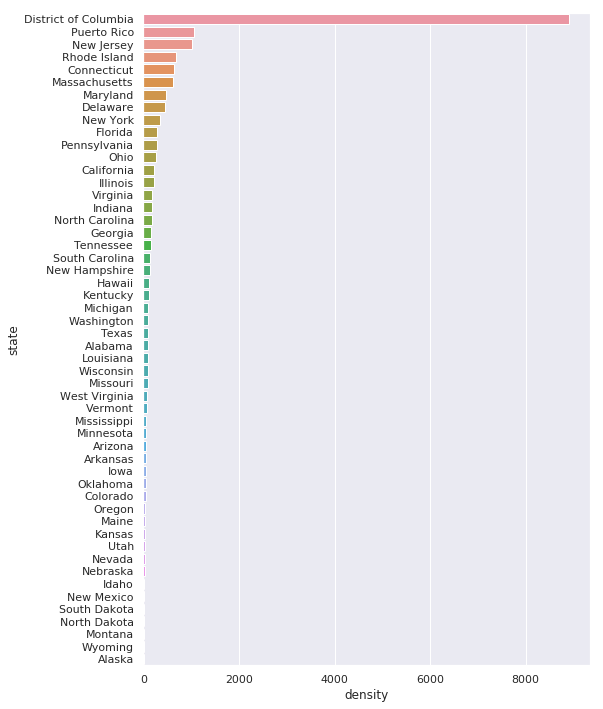

In [ ]:
# Don't run this cell to keep the outcome as your frame of reference
sns.barplot(y=data2010.index, x='density', data=data2010);

In [ ]:
# SOLUTION: Uncomment and execute the line below to get help
#disp(hint + '09-03-bar')

This type of messy data merging is a common task when trying to answer questions using real-world data sources.
I hope that this example has given you an idea of the ways you can combine tools we've covered in order to gain insight from your data!

## Plotting a heatmap

Below, we will use the **plotly** package to plot a population density heatmap of the US states.

In [ ]:
import plotly.express as px

df = data2010.reset_index()
# exluding District of Columbia & Puerto Rico for the purpose of creating a state map
df = df[~df['state'].isin(['District of Columbia', 'Puerto Rico'])].reset_index()

fig = px.choropleth(locations=df['state/region'], locationmode="USA-states", color=df['density'], scope="usa")
fig.show()